# Problem Statement:
A group of customers were given an offer in person that they can get a loan at discounted rate and
processing fee will be waived off. A pilot campaign was conducted to get response from customers whether
they are interested in taking out a loan or not. Response was recorded and data was collected.
Based on data given we need to:
1) Build a model to predict whether customers will be interested in taking out a loan or not.

2) Identifying features which are most important

3) In case of black box models e.g. Random forest use SHAP, LIME to figure out features affecting the target variable

4) Approaching a customer has costs involved with it, hence find the profitable segments so that more customized marketing can be done.

5) Model will be needed on a monthly basis as this data gets updated each month.

In [1]:
# Importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [2]:
data=pd.read_csv("C:/Users/NEW/Desktop/Group Project -IPBA/Model_data.csv")

In [3]:
df = data.copy()

In [4]:
df.head()

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period
0,0,41,M,91519.92,SELF-EMP,38,926,15
1,0,52,M,117288.96,SAL,17,768,13
2,0,31,F,259827.44,SENP,8,816,5
3,0,45,F,26677.55,PROF,14,353,18
4,0,39,F,43440.31,SENP,1,751,31


In [5]:
df.shape

(20000, 8)

In [6]:
df.isnull().sum()

Target            0
Age               0
Gender            0
Balance           0
Occupation        0
No_OF_CR_TXNS     0
SCR               0
Holding_Period    0
dtype: int64

In [7]:
df.dtypes

Target              int64
Age                 int64
Gender             object
Balance           float64
Occupation         object
No_OF_CR_TXNS       int64
SCR                 int64
Holding_Period      int64
dtype: object

In [8]:
df.Target.value_counts(0)

0    18267
1     1733
Name: Target, dtype: int64

In [9]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.drop(["Target"], axis=1).describe()

,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period
count,20000.00,20000.00,20000.00,20000.00,20000.00
mean,38.40,146181.31,16.65,557.14,15.34
std,9.60,169812.53,12.98,260.52,8.95
min,21.00,0.00,0.00,100.00,1.00
25%,30.00,23736.92,7.00,333.00,8.00
50%,38.00,79755.74,13.00,560.00,16.00
75%,47.00,217310.63,22.00,784.00,23.00
max,55.00,1246966.77,50.00,999.00,31.00


In [10]:
# Age bracketing
def Age_bkt(x):
    if x<=30:
        return "30 or less"
    elif 30<x<=50:
        return "btwn 31-50"
    else:
        return "more than 50"
    
# Approx no of respondents between 30-40 and 40-50 are identical and hence both are grouped together

In [11]:
df['Age_Bkt']=df['Age'].map(Age_bkt)
df=df.drop(['Age'],axis=1)
df.head()

,Target,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period,Age_Bkt
0,0,M,91519.92,SELF-EMP,38,926,15,btwn 31-50
1,0,M,117288.96,SAL,17,768,13,more than 50
2,0,F,259827.44,SENP,8,816,5,btwn 31-50
3,0,F,26677.55,PROF,14,353,18,btwn 31-50
4,0,F,43440.31,SENP,1,751,31,btwn 31-50


## Checking relation between Target and Categorical Variables

### Checking relation between Age Bracket and target

<AxesSubplot:xlabel='Age_Bkt'>

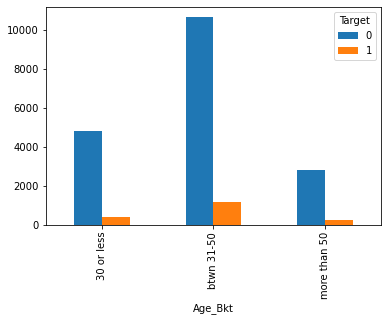

In [12]:
pd.crosstab(df.Age_Bkt, df.Target).plot.bar()

<AxesSubplot:xlabel='Age_Bkt'>

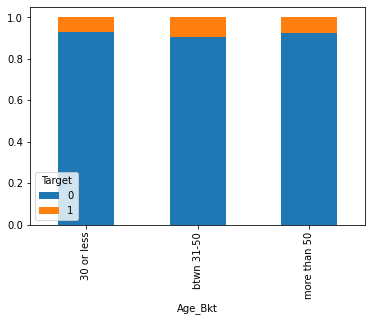

In [13]:
pd.crosstab(index = df.Age_Bkt, columns = df.Target, normalize= 'index').plot.bar(stacked = True)

#### There are more people in the age bracket of 31-50 years. Also ratio of people responding to the campaign is more in this group. However, by looking at the stacked bar chart it can be infered that Target response is less dependent on Age

### Checking relation between Gender and Target

<AxesSubplot:xlabel='Gender'>

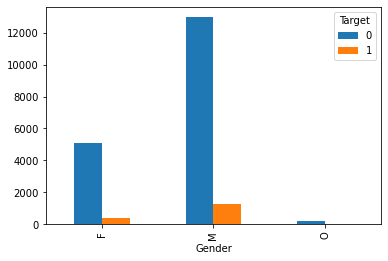

In [14]:
pd.crosstab(df.Gender, df.Target).plot.bar()

<AxesSubplot:xlabel='Gender'>

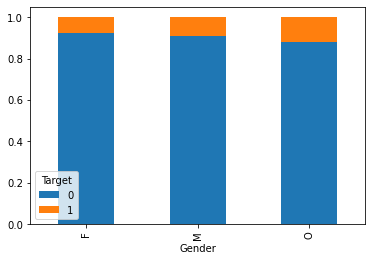

In [15]:
pd.crosstab(index = df.Gender, columns = df.Target, normalize= 'index').plot.bar(stacked = True)

#### The population of gender "O" is very low in comparision with "M" & "F". However, proportion of gender "O" of responding to campaign is more than M & F. Hence we shouldn't be ignoring "O". Bank should consider approaching them more.

### Checking relation between Occupation and Target

<AxesSubplot:xlabel='Occupation'>

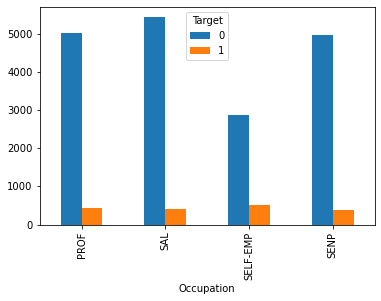

In [16]:
pd.crosstab(df.Occupation, df.Target).plot.bar()

<AxesSubplot:xlabel='Occupation'>

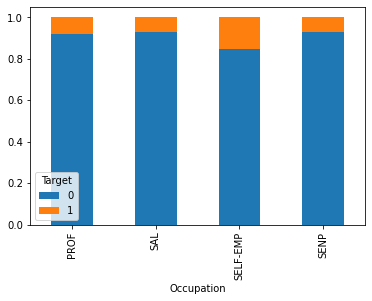

In [17]:
pd.crosstab(index = df.Occupation, columns = df.Target, normalize= 'index').plot.bar(stacked = True) 

#### Total number of people respondin to campaign is almost same for each variety of Occupation. However, ratio of Self employed people Self employed people responding to campaign is more.

## Checking relation between Target and Continuous Variables 

### Checking relation between Balance and Target

<AxesSubplot:xlabel='Target', ylabel='Balance'>

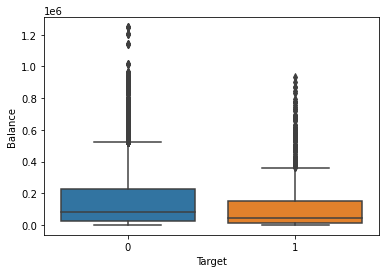

In [18]:
# Plotting box plot of balance w.r.t Target
sns.boxplot(x=df.Target, y=df.Balance)

#### There is minor shift in medians of Balance for Target 0 & 1. Hence, "Balance" is not strong parameter for predicting customer response. 

<AxesSubplot:xlabel='Target', ylabel='No_OF_CR_TXNS'>

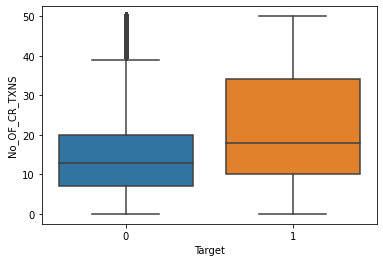

In [19]:
# Plotting box plot of No. of Txn w.r.t Target
sns.boxplot(x=df.Target, y=df.No_OF_CR_TXNS)

#### There is significant shift in medians of No of Cr Txns for Target 0 & 1. Hence, it can be infered that the No of Cr Txns is strong parameter for prediction of customer response

<AxesSubplot:xlabel='Target', ylabel='SCR'>

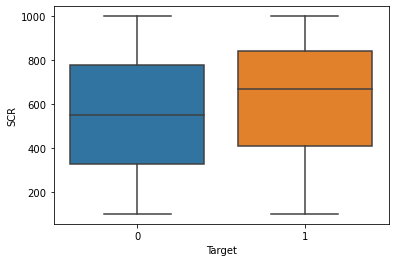

In [20]:
# Plotting box plot of SCR w.r.t Target
sns.boxplot(x=df.Target, y=df.SCR)

#### There is shift in medians of SCR for Target 0 & 1, however, distributions are overlapped. Hence, "SCR" is not strong parameter for predicting customer response. 

<AxesSubplot:xlabel='Target', ylabel='Holding_Period'>

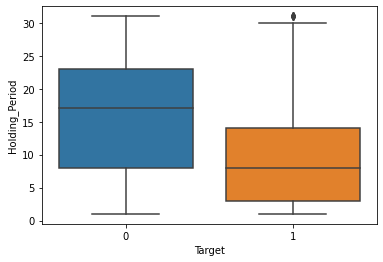

In [21]:
# Plotting box plot of Holding period w.r.t Target
sns.boxplot(x=df.Target, y=df.Holding_Period)

#### There is significant shift in medians of "Holding Period" for Target 0 & 1. Hence, it can be infered that "Holding Period" is strong parameter for prediction of customer response

### Checking co-relation among variables

In [22]:
corr=df[['Balance','No_OF_CR_TXNS','SCR','Holding_Period']].corr()

In [23]:
corr.style.background_gradient(cmap='viridis')

,Balance,No_OF_CR_TXNS,SCR,Holding_Period
Balance,1.000000,-0.135032,-0.015087,0.022917
No_OF_CR_TXNS,-0.135032,1.000000,0.003036,-0.026593
SCR,-0.015087,0.003036,1.000000,-0.030739
Holding_Period,0.022917,-0.026593,-0.030739,1.000000


#### There is little or no co-relation within independent variables

### Checking distribution of continuous variables 

array([[<AxesSubplot:title={'center':'Balance'}>,
        <AxesSubplot:title={'center':'No_OF_CR_TXNS'}>],
       [<AxesSubplot:title={'center':'SCR'}>,
        <AxesSubplot:title={'center':'Holding_Period'}>]], dtype=object)

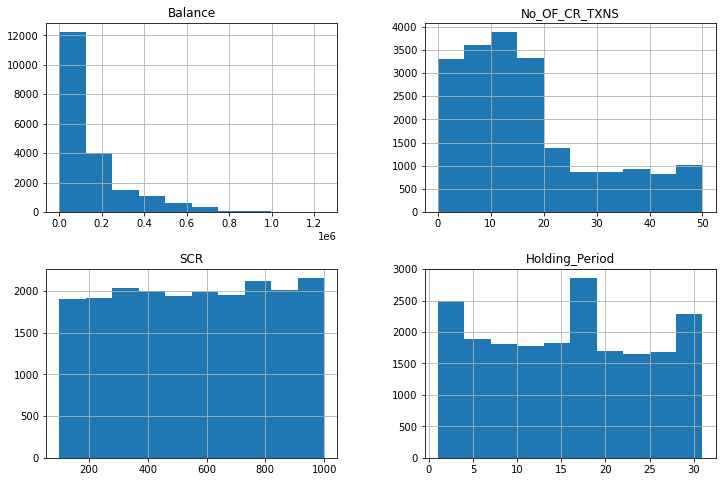

In [24]:
df.hist(["Balance","No_OF_CR_TXNS", "SCR", "Holding_Period" ], figsize = (12,8))

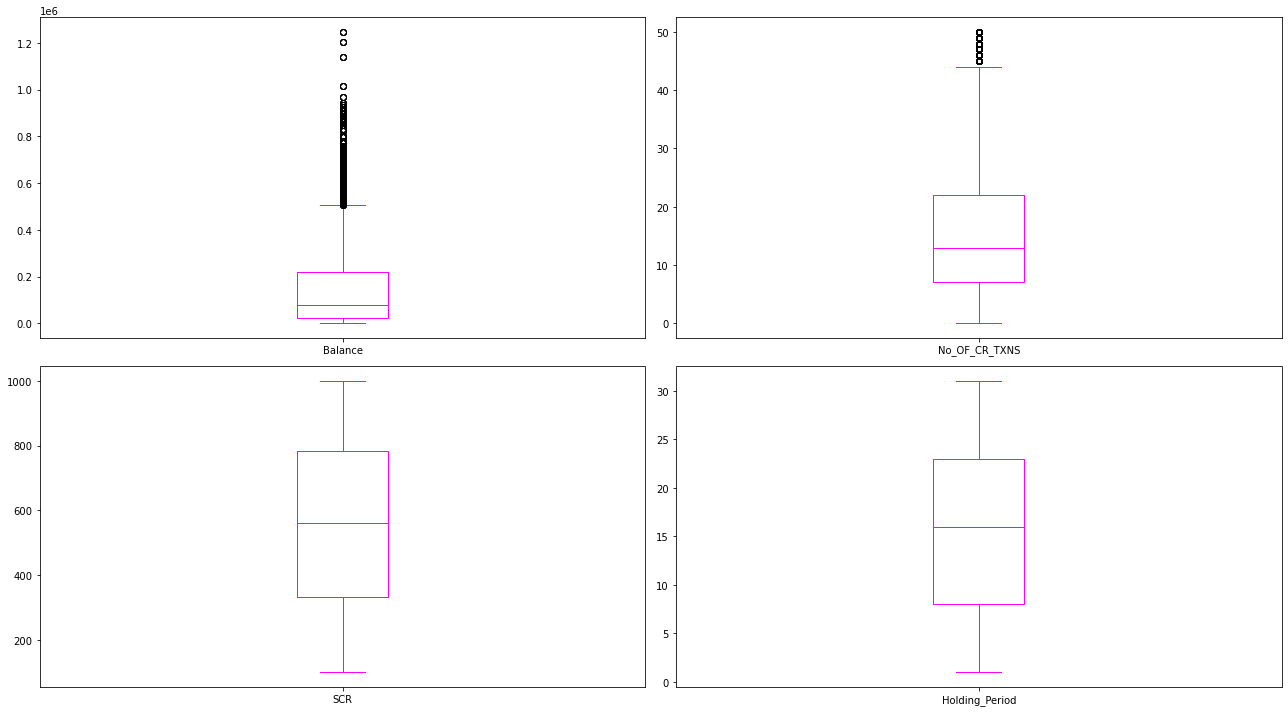

In [25]:
df.drop(["Target"], axis=1).plot(kind = 'box', subplots = True, layout = (2,2), sharex = False, color = 'magenta', figsize = (18,10))
plt.tight_layout()
plt.show()

#### There are large no. of outliers in Balance and No of Cr Txns. The distrubtions of Balance and No of Cr Txns are skewed 

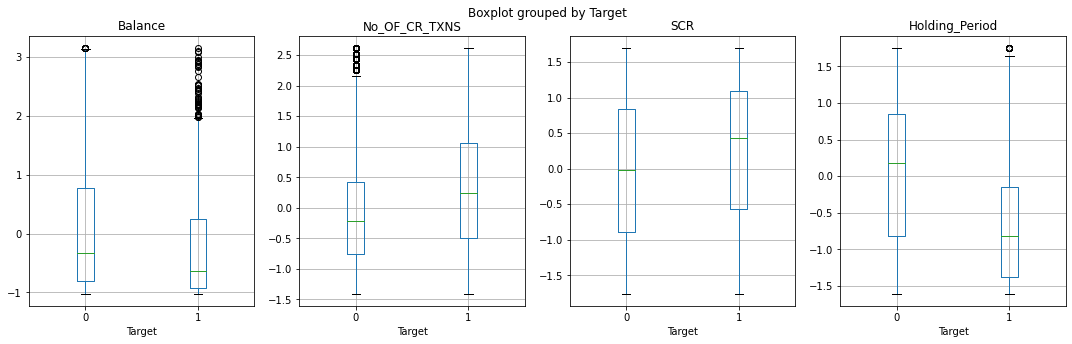

In [52]:
# Box plots for Categorical Target Variable "Target" and continuous predictors
ContinuousColsList=['Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period']

import matplotlib.pyplot as plt
fig, PlotCanvas=plt.subplots(nrows=1, ncols=len(ContinuousColsList), figsize=(18,5))

# Creating box plots for each continuous predictor against the Target Variable "Target"
for PredictorCol , i in zip(ContinuousColsList, range(len(ContinuousColsList))):
    df.boxplot(column=PredictorCol, by='Target', figsize=(5,5), vert=True, ax=PlotCanvas[i])

In [14]:
# Checking skewness of continuous variables
df.drop(["Target"], axis=1).agg(['skew']).transpose()

,skew
Balance,1.80
No_OF_CR_TXNS,0.95
SCR,-0.03
Holding_Period,0.03


#### SCR and Holding period are fairly symmetrical (Skewness -0.5 to 0.5)
#### No of Cr Txns is moderately skewed (-0.5 to -1.0 and 0.5 to 1.0)
#### Balance is highly skewed (< -1.0 and > 1.0)

## Data Preprocessing

### Outlier Treatment by quantile method. Outliers are contained within maximum and minimum (between Q3 + 1.5*IQR and Q1 -1.5*IQR)

In [15]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
IQR

Target                0.00
Balance          193573.72
No_OF_CR_TXNS        15.00
SCR                 451.00
Holding_Period       15.00
dtype: float64

In [16]:
df["Balance"] = np.where(df["Balance"] <(Q1["Balance"]-1.5*IQR["Balance"]),Q1["Balance"],df['Balance'])

In [17]:
df["Balance"] = np.where(df["Balance"] >(Q3["Balance"]+1.5*IQR["Balance"]),Q3["Balance"],df['Balance'])

In [18]:
df["No_OF_CR_TXNS"] = np.where(df["No_OF_CR_TXNS"] <(Q1["No_OF_CR_TXNS"]-1.5*IQR["No_OF_CR_TXNS"]),Q1["No_OF_CR_TXNS"],df['No_OF_CR_TXNS'])

In [19]:
df["No_OF_CR_TXNS"] = np.where(df["No_OF_CR_TXNS"] >(Q3["No_OF_CR_TXNS"]+1.5*IQR["No_OF_CR_TXNS"]),Q3["No_OF_CR_TXNS"],df['No_OF_CR_TXNS'])

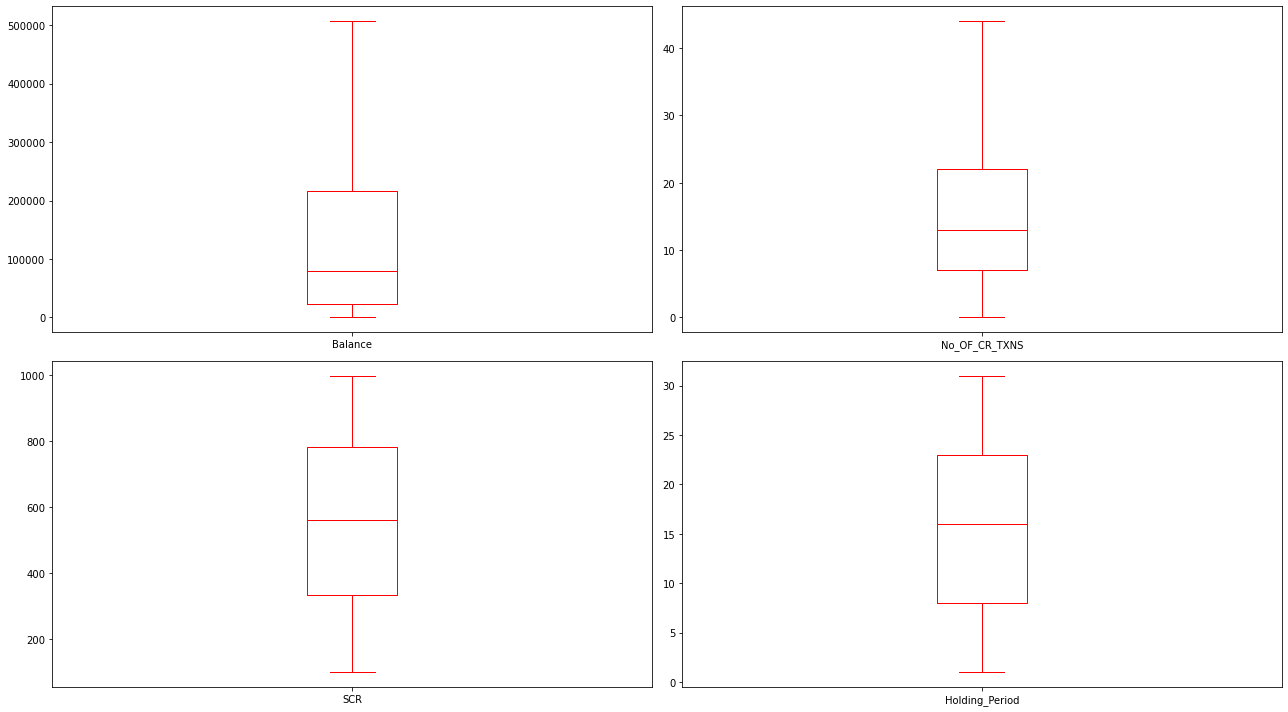

In [32]:
df.drop(["Target"], axis=1).plot(kind = 'box', color = 'red', subplots = True, layout = (2,2), sharex = False, figsize = (18,10))
plt.tight_layout()
plt.show()

### Normalization of Numerical data using standard scaler

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[["Balance", "No_OF_CR_TXNS", "SCR", "Holding_Period"]] = scaler.fit_transform(df[["Balance", "No_OF_CR_TXNS", "SCR", "Holding_Period"]])

In [21]:
df.head()

,Target,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period,Age_Bkt
0,0,M,-0.27,SELF-EMP,2.07,1.42,-0.04,btwn 31-50
1,0,M,-0.05,SAL,0.15,0.81,-0.26,more than 50
2,0,F,1.12,SENP,-0.67,0.99,-1.16,btwn 31-50
3,0,F,-0.80,PROF,-0.12,-0.78,0.30,btwn 31-50
4,0,F,-0.66,SENP,-1.31,0.74,1.75,btwn 31-50


In [22]:
df.drop(["Target"], axis=1).agg(['skew']).transpose()

,skew
Balance,1.11
No_OF_CR_TXNS,0.79
SCR,-0.03
Holding_Period,0.03


In [23]:
# Introducing dummy variables for categorical data
df = pd.get_dummies(df)

In [24]:
df.head()

,Target,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_F,Gender_M,Gender_O,Occupation_PROF,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP,Age_Bkt_30 or less,Age_Bkt_btwn 31-50,Age_Bkt_more than 50
0,0,-0.27,2.07,1.42,-0.04,0,1,0,0,0,1,0,0,1,0
1,0,-0.05,0.15,0.81,-0.26,0,1,0,0,1,0,0,0,0,1
2,0,1.12,-0.67,0.99,-1.16,1,0,0,0,0,0,1,0,1,0
3,0,-0.80,-0.12,-0.78,0.30,1,0,0,1,0,0,0,0,1,0
4,0,-0.66,-1.31,0.74,1.75,1,0,0,0,0,0,1,0,1,0


In [25]:
X = df.drop(['Target'], axis=1)
y = df.Target

In [26]:
# Splitting the data into train and test set
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.25, random_state=200)

### % of Target 1 w.r.t. total population is very less i.e. approx. 9%. Hence, the training data is upsampled using SMOTENC
### pip install -U imbalanced-learn

In [27]:
from imblearn.over_sampling import SMOTENC

In [28]:
smotenc = SMOTENC([4,5,6,7,8,9,10,11,12,13],random_state = 400) # column position of categorical data have been specified
X_train_up, y_train_up = smotenc.fit_resample(X_train, y_train)

In [29]:
# Checking the upsampled data 
df_y_up=pd.DataFrame(y_train_up)
df_X_up=pd.DataFrame(X_train_up, columns = X.columns)
df_up = pd.concat([df_y_up, df_X_up], axis=1)
df_up.head()

,Target,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_F,Gender_M,Gender_O,Occupation_PROF,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP,Age_Bkt_30 or less,Age_Bkt_btwn 31-50,Age_Bkt_more than 50
0,0,1.45,0.24,-0.53,-0.15,0,1,0,0,0,0,1,0,1,0
1,0,-0.32,-1.40,-1.01,0.30,1,0,0,1,0,0,0,0,1,0
2,0,0.40,0.24,0.43,0.41,0,1,0,0,1,0,0,0,1,0
3,0,-0.40,-1.22,1.60,0.74,0,1,0,0,0,1,0,0,0,1
4,0,1.47,0.24,-1.25,-1.60,0,1,0,1,0,0,0,0,1,0


In [30]:
df_up.shape

(27378, 15)

In [31]:
df_up.Target.value_counts(0)

1    13689
0    13689
Name: Target, dtype: int64

# Analysis with Logistic Regression Classifier

## Logisting regression with upsampled data

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
lr=LogisticRegression(random_state = 400)
lr.fit(X_train_up, y_train_up)
lr.score(X_test, y_test)

0.731

In [47]:
y_predicted1=lr.predict(X_test)
metrics.confusion_matrix(y_test,y_predicted1)

array([[3378, 1200],
       [ 145,  277]])

In [48]:
print(classification_report(y_test, y_predicted1))

              precision    recall  f1-score   support

           0       0.96      0.74      0.83      4578
           1       0.19      0.66      0.29       422

    accuracy                           0.73      5000
   macro avg       0.57      0.70      0.56      5000
weighted avg       0.89      0.73      0.79      5000



### Performing gridsearch CV

In [49]:
# only l2 penalty is selected as other penalties are not supported by all solver
lr_param_grid = dict(penalty = ['l2'], solver =['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

In [50]:
lr_grid = GridSearchCV(lr, param_grid= lr_param_grid, cv=10, n_jobs=-1, scoring = 'f1_weighted')

In [51]:
lr_grid.fit(X_train_up, y_train_up)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=400), n_jobs=-1,
             param_grid={'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1_weighted')

In [52]:
lr_grid.best_params_

{'penalty': 'l2', 'solver': 'liblinear'}

In [53]:
lr=LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = 400)

In [54]:
lr.fit(X_train_up, y_train_up)

LogisticRegression(random_state=400, solver='liblinear')

In [55]:
y_predicted1=lr.predict(X_test)
metrics.confusion_matrix(y_test,y_predicted1)

array([[3377, 1201],
       [ 145,  277]])

In [56]:
print(classification_report(y_test, y_predicted1))

              precision    recall  f1-score   support

           0       0.96      0.74      0.83      4578
           1       0.19      0.66      0.29       422

    accuracy                           0.73      5000
   macro avg       0.57      0.70      0.56      5000
weighted avg       0.89      0.73      0.79      5000



### Plotting ROC curve and getting AUC

In [57]:
predict_prob_test1 = lr.predict_proba(X_test)
predict_prob_train1 = lr.predict_proba(X_train_up)

In [58]:
# Getting ROC_AUC for test data (target 1)
fpr_test1, tpr_test1, _ = roc_curve(y_test, predict_prob_test1[:, 1])
roc_auc_test1 = auc(fpr_test1, tpr_test1)

# getting ROC_AUC for train data
fpr_train1, tpr_train1, _ = roc_curve(y_train_up, predict_prob_train1[:, 1])
roc_auc_train1 = auc(fpr_train1, tpr_train1)

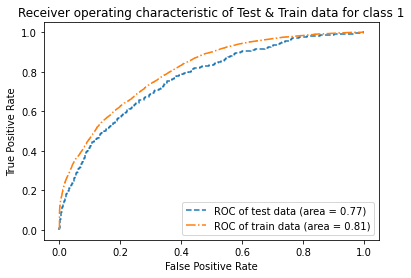

In [59]:
# Plotting ROC curve for test data
plt.plot(fpr_test1, tpr_test1, linestyle='--', label='ROC of test data (area = {:0.2f})'''.format(roc_auc_test1))

#Plotting ROC curve for train data
plt.plot(fpr_train1, tpr_train1, linestyle='-.',label='ROC of train data (area = {:0.2f})'''.format(roc_auc_train1))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Test & Train data for class 1')
plt.legend(loc="lower right")
plt.show()

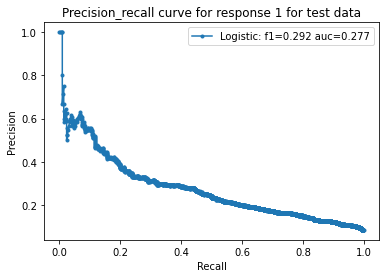

In [60]:
# Plotting Precision_recall curve for response 1 in test data
lr_precision, lr_recall, _ = precision_recall_curve(y_test, predict_prob_test1[:,1])
lr_f1, lr_auc = f1_score(y_test, y_predicted1), auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision_recall curve for response 1 for test data')
plt.legend()
plt.show()

### Obtaining Fetaure importance from Logistic Regression Model

In [61]:
coeff = lr.coef_[0]
print(coeff)

[-0.3399697   0.33867581  0.21238873 -0.94293363 -0.90703163 -0.8091076
 -2.69515807 -4.44413172 -4.60201932 -3.7517525  -4.30974369 -3.73007051
 -3.29564623 -3.99862583]


In [62]:
import math

In [63]:
features = pd.DataFrame(X.columns.tolist(), columns = ["Feature"])

In [64]:
features["Importance"]=pow(math.e,coeff)

In [65]:
features = features.sort_values(by=["Importance"])

<AxesSubplot:ylabel='Feature'>

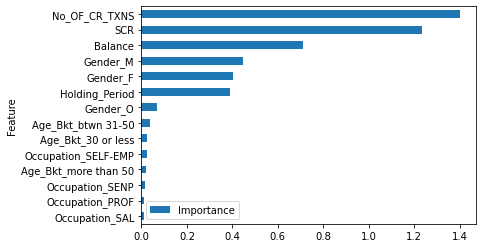

In [66]:
features.plot.barh( x="Feature", y = "Importance",)

## Analysis with Decision Tree Classifier using upsampled data

In [67]:
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(criterion = 'gini', max_depth=3, random_state=200)

In [68]:
clf.fit(X_train_up, y_train_up)
clf.score(X_test, y_test)

0.6772

In [69]:
y_predicted2=clf.predict(X_test)
metrics.confusion_matrix(y_test,y_predicted2)

array([[3117, 1461],
       [ 153,  269]])

In [70]:
print(classification_report(y_test, y_predicted2))

              precision    recall  f1-score   support

           0       0.95      0.68      0.79      4578
           1       0.16      0.64      0.25       422

    accuracy                           0.68      5000
   macro avg       0.55      0.66      0.52      5000
weighted avg       0.89      0.68      0.75      5000



In [71]:
# Plotting ROC curve and getting AUC
predict_prob_test2 = clf.predict_proba(X_test)
predict_prob_train2 = clf.predict_proba(X_train_up)

In [72]:
# Getting ROC_AUC for test data
fpr_test2, tpr_test2, _ = roc_curve(y_test, predict_prob_test2[:, 1])
roc_auc_test2 = auc(fpr_test2, tpr_test2)

# getting ROC_AUC for train data
fpr_train2, tpr_train2, _ = roc_curve(y_train_up, predict_prob_train2[:, 1])
roc_auc_train2 = auc(fpr_train2, tpr_train2)

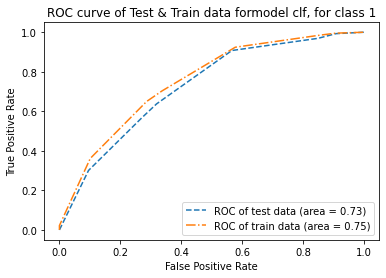

In [73]:
# Plotting ROC curve for test data
plt.plot(fpr_test2, tpr_test2, linestyle='--', label='ROC of test data (area = {:0.2f})'''.format(roc_auc_test2))

#Plotting ROC curve for train data
plt.plot(fpr_train2, tpr_train2, linestyle='-.',label='ROC of train data (area = {:0.2f})'''.format(roc_auc_train2))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Test & Train data formodel clf, for class 1')
plt.legend(loc="lower right")
plt.show()

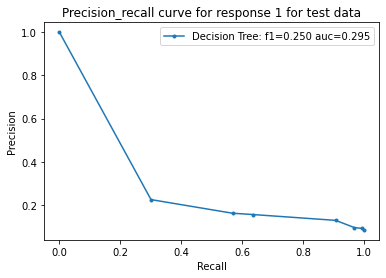

In [74]:
# Plotting Precision_recall curve for response 1 in test data
clf_precision, clf_recall, _ = precision_recall_curve(y_test, predict_prob_test2[:,1])
clf_f1, clf_auc = f1_score(y_test, y_predicted2), auc(clf_recall, clf_precision)

plt.plot(clf_recall, clf_precision, marker='.', label='Decision Tree: f1=%.3f auc=%.3f' % (clf_f1, clf_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision_recall curve for response 1 for test data')
plt.legend()
plt.show()

### Hyperparameter tuning with criterion gini and entropy

In [75]:
clf_param1 = dict(criterion = ['gini', 'entropy'], max_depth=[3])
# Max depth is fixed at 3 because after this depth difference between AUC of ROC curves for train and test data increases i.e. model is overfitting

In [77]:
clf_grid1 = GridSearchCV(estimator = clf, param_grid = clf_param1, cv = 5, n_jobs = -1, scoring='f1_weighted')

In [78]:
clf_grid1.fit(X_train_up, y_train_up)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=200),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3]},
             scoring='f1_weighted')

In [79]:
clf_grid1.best_params_

{'criterion': 'gini', 'max_depth': 3}

#### There is no change in the hyperparameter i.e. base model "clf" remains same.

### Hyperparameter tuning using min impurity decrease

In [80]:
clf_param2 = dict(criterion = ['gini', 'entropy'], min_impurity_decrease = [0.01,0.02,0.05,0.1])

In [81]:
clf_grid2 = GridSearchCV(estimator = clf, param_grid = clf_param2, cv = 5, n_jobs = -1, scoring='f1_weighted')

In [82]:
clf_grid2.fit(X_train_up, y_train_up)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=200),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_impurity_decrease': [0.01, 0.02, 0.05, 0.1]},
             scoring='f1_weighted')

In [83]:
clf_grid2.best_params_

{'criterion': 'entropy', 'min_impurity_decrease': 0.01}

In [84]:
clf2=DecisionTreeClassifier(criterion = 'entropy', min_impurity_decrease = 0.01, random_state=200)

In [85]:
clf2.fit(X_train_up, y_train_up)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.01,
                       random_state=200)

In [86]:
clf2.score(X_test, y_test)

0.737

In [87]:
y_pred_clf2=clf2.predict(X_test)
metrics.confusion_matrix(y_test,y_pred_clf2)

array([[3461, 1117],
       [ 198,  224]])

In [88]:
print(classification_report(y_test, y_pred_clf2))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84      4578
           1       0.17      0.53      0.25       422

    accuracy                           0.74      5000
   macro avg       0.56      0.64      0.55      5000
weighted avg       0.88      0.74      0.79      5000



### Plotting ROC curve and getting AUC

In [89]:
clf2_pred_test = clf2.predict_proba(X_test)
clf2_pred_train = clf2.predict_proba(X_train_up)

In [90]:
# Getting ROC_AUC for test data
clf2_fpr_test, clf2_tpr_test, _ = roc_curve(y_test, clf2_pred_test[:, 1])
clf2_roc_auc_test = auc(clf2_fpr_test, clf2_tpr_test)

# getting ROC_AUC for train data
clf2_fpr_train, clf2_tpr_train, _ = roc_curve(y_train_up, clf2_pred_train[:, 1])
clf2_roc_auc_train = auc(clf2_fpr_train, clf2_tpr_train)

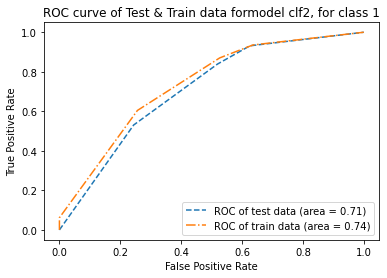

In [91]:
# Plotting ROC curve for test data
plt.plot(clf2_fpr_test, clf2_tpr_test, linestyle='--', label='ROC of test data (area = {:0.2f})'''.format(clf2_roc_auc_test))

#Plotting ROC curve for train data
plt.plot(clf2_fpr_train, clf2_tpr_train, linestyle='-.',label='ROC of train data (area = {:0.2f})'''.format(clf2_roc_auc_train))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Test & Train data formodel clf2, for class 1')
plt.legend(loc="lower right")
plt.show()

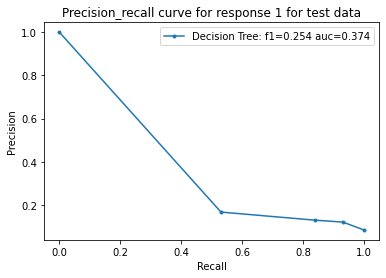

In [92]:
# Plotting Precision_recall curve for response 1 in test data
clf2_precision, clf2_recall, _ = precision_recall_curve(y_test, clf2_pred_test[:,1])
clf2_f1, clf2_auc = f1_score(y_test, y_pred_clf2), auc(clf2_recall, clf2_precision)

plt.plot(clf2_recall, clf2_precision, marker='.', label='Decision Tree: f1=%.3f auc=%.3f' % (clf2_f1, clf2_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision_recall curve for response 1 for test data')
plt.legend()
plt.show()

### Out of the two Decision Tree Model created i.e. clf (criterion = 'gini', max_depth=3, random_state=200) and clf2 (criterion = 'entropy', min_impurity_decrease = 0.01, random_state=200), model "clf" is better because of having better "Recall" for target class-1, better "AUC-ROC", less difference in "AUC-ROC" for train and test data

### Ploting Decision tree for model clf (criterion = 'gini', max_depth=3, random_state=200)

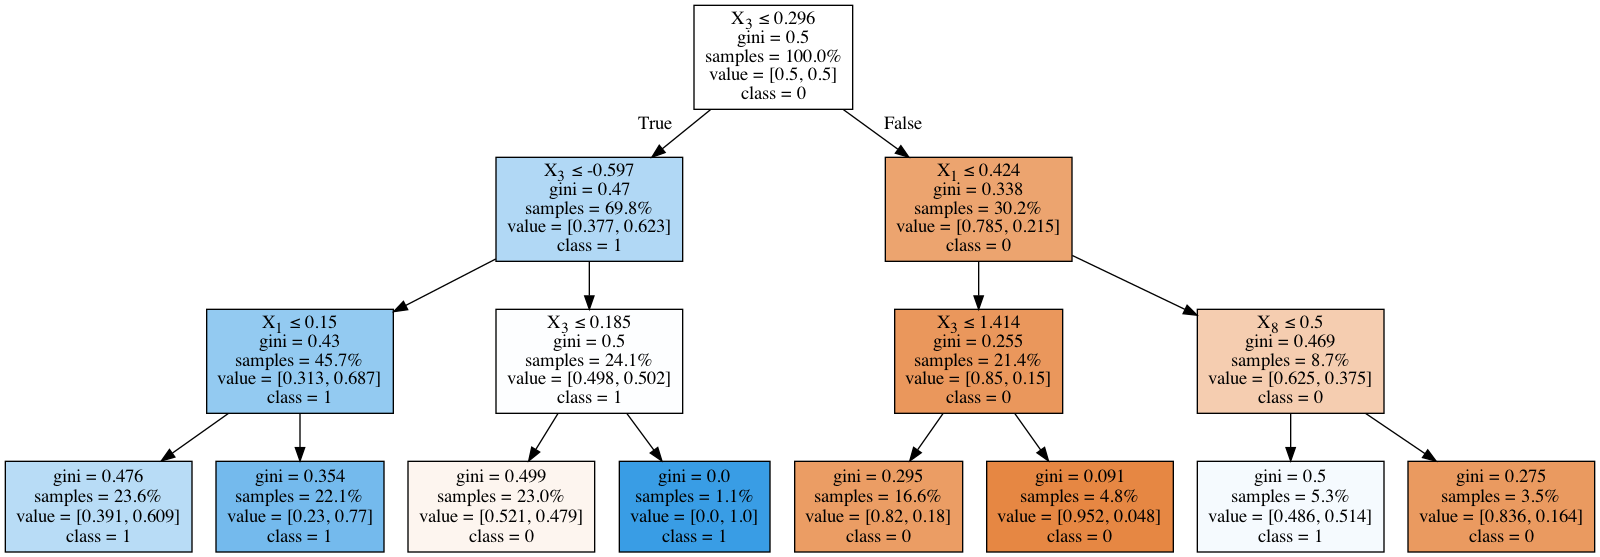

In [93]:
import pydotplus
dot_data=tree.export_graphviz(clf, out_file=None,
                              class_names=["0","1"], 
                              filled=True, 
                              special_characters=True, 
                              proportion=True)
graph=pydotplus.graph_from_dot_data(dot_data)
from IPython.display import Image
Image(graph.create_png())

### Feature Importance obtained with model clf

In [94]:
imp_feature=pd.Series(clf.feature_importances_,index=X.columns.tolist())
imp_feature.sort_values(ascending=False)

Holding_Period         0.84
No_OF_CR_TXNS          0.12
Occupation_SAL         0.05
Balance                0.00
SCR                    0.00
Gender_F               0.00
Gender_M               0.00
Gender_O               0.00
Occupation_PROF        0.00
Occupation_SELF-EMP    0.00
Occupation_SENP        0.00
Age_Bkt_30 or less     0.00
Age_Bkt_btwn 31-50     0.00
Age_Bkt_more than 50   0.00
dtype: float64

# Analysis using Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rfc=RandomForestClassifier(n_estimators=80,max_depth = 3, oob_score=True,random_state=200)

In [97]:
rfc.fit(X_train_up, y_train_up)

RandomForestClassifier(max_depth=3, n_estimators=80, oob_score=True,
                       random_state=200)

In [98]:
rfc.oob_score_

0.706260501132296

In [99]:
y_pred_rfc=rfc.predict(X_test)
metrics.confusion_matrix(y_test,y_pred_rfc)

array([[2950, 1628],
       [ 119,  303]])

In [100]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.96      0.64      0.77      4578
           1       0.16      0.72      0.26       422

    accuracy                           0.65      5000
   macro avg       0.56      0.68      0.51      5000
weighted avg       0.89      0.65      0.73      5000



### Plotting ROC curve and getting AUC

In [101]:
rfc_pred_test = rfc.predict_proba(X_test)
rfc_pred_train = rfc.predict_proba(X_train_up)

In [102]:
# Getting ROC_AUC for test data
rfc_fpr_test, rfc_tpr_test, _ = roc_curve(y_test, rfc_pred_test[:, 1])
rfc_roc_auc_test = auc(rfc_fpr_test, rfc_tpr_test)

# getting ROC_AUC for train data
rfc_fpr_train, rfc_tpr_train, _ = roc_curve(y_train_up, rfc_pred_train[:, 1])
rfc_roc_auc_train = auc(rfc_fpr_train, rfc_tpr_train)

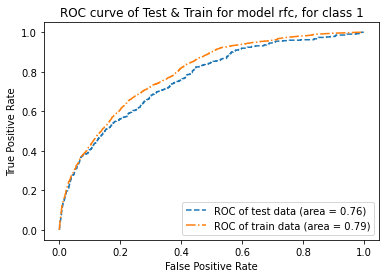

In [103]:
# Plotting ROC curve for test data
plt.plot(rfc_fpr_test, rfc_tpr_test, linestyle='--', label='ROC of test data (area = {:0.2f})'''.format(rfc_roc_auc_test))

#Plotting ROC curve for train data
plt.plot(rfc_fpr_train, rfc_tpr_train, linestyle='-.',label='ROC of train data (area = {:0.2f})'''.format(rfc_roc_auc_train))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Test & Train for model rfc, for class 1')
plt.legend(loc="lower right")
plt.show()

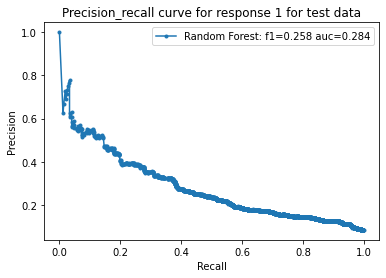

In [104]:
# Plotting Precision_recall curve for response 1 in test data
rfc_precision, rfc_recall, _ = precision_recall_curve(y_test, rfc_pred_test[:,1])
rfc_f1, rfc_auc = f1_score(y_test, y_pred_rfc), auc(rfc_recall, rfc_precision)

plt.plot(rfc_recall, rfc_precision, marker='.', label='Random Forest: f1=%.3f auc=%.3f' % (rfc_f1, rfc_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision_recall curve for response 1 for test data')
plt.legend()
plt.show()

### Performing Grid Search CV for best estimator using gini/entropy criterion

In [105]:
rfc_param1=dict(n_estimators=np.arange(60,300,10),criterion = ['gini', 'entropy'], max_depth=[4])
# Max depth is fixed at 4 because after this depth difference between AUC of ROC curves for train and test data increases i.e. model is overfitting

In [107]:
rfc_grid1 = GridSearchCV(estimator = rfc, param_grid = rfc_param1, n_jobs = -1, scoring='f1_weighted')

In [133]:
rfc_grid1.fit(X_train_up, y_train_up)

GridSearchCV(estimator=RandomForestClassifier(max_depth=3, n_estimators=80,
                                              oob_score=True,
                                              random_state=200),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [4],
                         'n_estimators': array([ 60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180,
       190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])},
             scoring='f1_weighted')

In [135]:
rfc_grid1.best_params_

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 140}

In [108]:
rfc1=RandomForestClassifier(n_estimators=140, criterion = 'gini', max_depth = 4, oob_score=True,random_state=200)

In [109]:
rfc1.fit(X_train_up, y_train_up)

RandomForestClassifier(max_depth=4, n_estimators=140, oob_score=True,
                       random_state=200)

In [110]:
rfc1.oob_score_

0.7241580831324421

In [111]:
y_pred_rfc1=rfc1.predict(X_test)
metrics.confusion_matrix(y_test,y_pred_rfc1)

array([[2994, 1584],
       [ 116,  306]])

In [112]:
print(classification_report(y_test, y_pred_rfc1))

              precision    recall  f1-score   support

           0       0.96      0.65      0.78      4578
           1       0.16      0.73      0.26       422

    accuracy                           0.66      5000
   macro avg       0.56      0.69      0.52      5000
weighted avg       0.90      0.66      0.74      5000



### Plotting ROC curve and getting AUC

In [113]:
rfc1_pred_test = rfc1.predict_proba(X_test)
rfc1_pred_train = rfc1.predict_proba(X_train_up)

In [114]:
# Getting ROC_AUC for test data
rfc1_fpr_test, rfc1_tpr_test, _ = roc_curve(y_test, rfc1_pred_test[:, 1])
rfc1_roc_auc_test = auc(rfc1_fpr_test, rfc1_tpr_test)

# getting ROC_AUC for train data
rfc1_fpr_train, rfc1_tpr_train, _ = roc_curve(y_train_up, rfc1_pred_train[:, 1])
rfc1_roc_auc_train = auc(rfc1_fpr_train, rfc1_tpr_train)

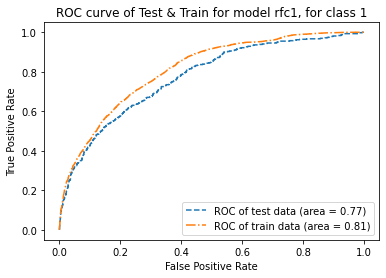

In [115]:
# Plotting ROC curve for test data
plt.plot(rfc1_fpr_test, rfc1_tpr_test, linestyle='--', label='ROC of test data (area = {:0.2f})'''.format(rfc1_roc_auc_test))

#Plotting ROC curve for train data
plt.plot(rfc1_fpr_train, rfc1_tpr_train, linestyle='-.',label='ROC of train data (area = {:0.2f})'''.format(rfc1_roc_auc_train))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Test & Train for model rfc1, for class 1')
plt.legend(loc="lower right")
plt.show()

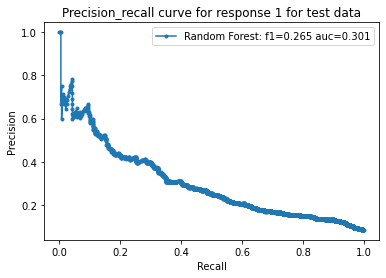

In [116]:
# Plotting Precision_recall curve for response 1 in test data
rfc1_precision, rfc1_recall, _ = precision_recall_curve(y_test, rfc1_pred_test[:,1])
rfc1_f1, rfc1_auc = f1_score(y_test, y_pred_rfc1), auc(rfc1_recall, rfc1_precision)

plt.plot(rfc1_recall, rfc1_precision, marker='.', label='Random Forest: f1=%.3f auc=%.3f' % (rfc1_f1, rfc1_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision_recall curve for response 1 for test data')
plt.legend()
plt.show()

### Performing Randomized Search CV for best estimator using Minimum Impurity Decrease

In [117]:
rfc_param2=dict(n_estimators=np.arange(60,300,10),criterion = ['gini', 'entropy'], min_impurity_decrease = [0.01,0.02,0.05,0.1])

In [118]:
rfc_grid2 = GridSearchCV(estimator = rfc, param_grid = rfc_param2, n_jobs = -1, scoring='f1_weighted')

In [142]:
rfc_grid2.fit(X_train_up, y_train_up)

GridSearchCV(estimator=RandomForestClassifier(max_depth=3, n_estimators=80,
                                              oob_score=True,
                                              random_state=200),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_impurity_decrease': [0.01, 0.02, 0.05, 0.1],
                         'n_estimators': array([ 60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180,
       190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])},
             scoring='f1_weighted')

In [144]:
rfc_grid2.best_params_

{'criterion': 'entropy', 'min_impurity_decrease': 0.01, 'n_estimators': 270}

In [34]:
rfc2=RandomForestClassifier(n_estimators=270, criterion = 'entropy', min_impurity_decrease = 0.01, oob_score=True,random_state=200)

In [35]:
rfc2.fit(X_train_up, y_train_up)

RandomForestClassifier(criterion='entropy', min_impurity_decrease=0.01,
                       n_estimators=270, oob_score=True, random_state=200)

In [36]:
rfc2.oob_score_

0.6928190517934107

In [36]:
y_pred_rfc2=rfc2.predict(X_test)
metrics.confusion_matrix(y_test,y_pred_rfc2)

array([[2748, 1830],
       [  96,  326]], dtype=int64)

In [37]:
print(classification_report(y_test, y_pred_rfc2))

              precision    recall  f1-score   support

           0       0.97      0.60      0.74      4578
           1       0.15      0.77      0.25       422

    accuracy                           0.61      5000
   macro avg       0.56      0.69      0.50      5000
weighted avg       0.90      0.61      0.70      5000



### Plotting ROC curve and getting AUC

In [124]:
rfc2_pred_test = rfc2.predict_proba(X_test)
rfc2_pred_train = rfc2.predict_proba(X_train_up)

In [125]:
# Getting ROC_AUC for test data
rfc2_fpr_test, rfc2_tpr_test, _ = roc_curve(y_test, rfc2_pred_test[:, 1])
rfc2_roc_auc_test = auc(rfc2_fpr_test, rfc2_tpr_test)

# getting ROC_AUC for train data
rfc2_fpr_train, rfc2_tpr_train, _ = roc_curve(y_train_up, rfc2_pred_train[:, 1])
rfc2_roc_auc_train = auc(rfc2_fpr_train, rfc2_tpr_train)

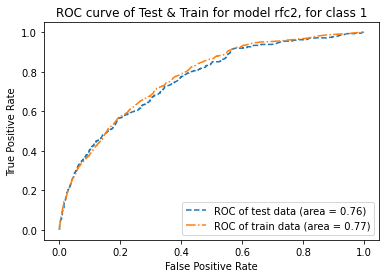

In [126]:
# Plotting ROC curve for test data
plt.plot(rfc2_fpr_test, rfc2_tpr_test, linestyle='--', label='ROC of test data (area = {:0.2f})'''.format(rfc2_roc_auc_test))

#Plotting ROC curve for train data
plt.plot(rfc2_fpr_train, rfc2_tpr_train, linestyle='-.',label='ROC of train data (area = {:0.2f})'''.format(rfc2_roc_auc_train))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Test & Train for model rfc2, for class 1')
plt.legend(loc="lower right")
plt.show()

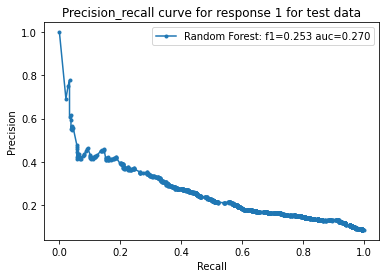

In [127]:
# Plotting Precision_recall curve for response 1 in test data
rfc2_precision, rfc2_recall, _ = precision_recall_curve(y_test, rfc2_pred_test[:,1])
rfc2_f1, rfc2_auc = f1_score(y_test, y_pred_rfc2), auc(rfc2_recall, rfc2_precision)

plt.plot(rfc2_recall, rfc2_precision, marker='.', label='Random Forest: f1=%.3f auc=%.3f' % (rfc2_f1, rfc2_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision_recall curve for response 1 for test data')
plt.legend()
plt.show()

### Out of the three Random Forest Model created i.e. rfc (n_estimators=80,max_depth = 3, oob_score=True,random_state=200), rfc1(n_estimators=140, criterion = 'gini', max_depth = 4, oob_score=True,random_state=200) and rfc2 (n_estimators=270, criterion = 'entropy', min_impurity_decrease = 0.01, oob_score=True,random_state=200), 3rd model rfc2 is chosen because of better recall value for target class-1, and less difference between ROC_AUC of test and train data

### Feature Importance obtained with model rfc2

In [128]:
imp_feature_rfc2=pd.Series(rfc2.feature_importances_,index=X.columns.tolist())
imp_feature_rfc2.sort_values(ascending=False)

Holding_Period         0.47
No_OF_CR_TXNS          0.19
Balance                0.14
Occupation_SELF-EMP    0.12
Age_Bkt_btwn 31-50     0.04
SCR                    0.03
Occupation_SAL         0.01
Age_Bkt_30 or less     0.00
Gender_F               0.00
Gender_M               0.00
Gender_O               0.00
Occupation_PROF        0.00
Occupation_SENP        0.00
Age_Bkt_more than 50   0.00
dtype: float64

## Model Selection

### Logistic Regression Model
#### Recall score for target class-1: 0.66
#### ROC_AUC for Test/Train = .77/.81
#### Precision_Recall_Curve AUC = .28

### Decision Tree Classifier
#### Recall score for target class-1: 0.64
#### ROC_AUC for Test/Train = .73/.75
#### Precision_Recall_Curve AUC = .29

### Random Forest Classifier
#### Recall score for target class-1: 0.77
#### ROC_AUC for Test/Train = .76/.77
#### Precision_Recall_Curve AUC = .27

### Considering the above Random Forest Model (rfc2) is chosen for better recall score of target class-1 and lesser difference between ROC_AUC of train and test data. Recall score has been given more priority as it indicates probability of identiying customer out of people who are actually going to respond to offer


# Comparing the models with K-Fold Cross Validation

In [129]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [130]:
scoring = {'accuracy' : make_scorer(accuracy_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'precision' : make_scorer(precision_score)}

In [131]:
lr_finalmodel=lr.fit(X_train_up, y_train_up)
clf_finalmodel=clf.fit(X_train_up, y_train_up)
rfc_finalmodel=rfc2.fit(X_train_up, y_train_up)
model_kfold = [lr_finalmodel, clf_finalmodel, rfc_finalmodel]
model_name = ["Logistic Regression", "Decision Tree", "Random Forest"]
mean_accuracy = []
mean_recall = [] 
mean_precision = []
mean_f1_score = []
a=0
for model_type in model_kfold:
    results_kfold = model_selection.cross_validate(model_type, X_train_up,y_train_up, cv=5, scoring=scoring)
    mean_accuracy.append(results_kfold['test_accuracy'].mean())
    mean_recall.append(results_kfold['test_recall'].mean())
    mean_f1_score.append(results_kfold['test_f1_score'].mean())
    mean_precision.append(results_kfold['test_f1_score'].mean())
    print("\n************** Model:", model_name[a], "**************" )
    print("Accuracy of folds: ")
    print(results_kfold['test_accuracy']," -> Mean Accuracy: %.2f" %  (mean_accuracy[a]))
    print("Recall of folds: ")
    print(results_kfold['test_recall']," -> Mean_Recall: %.2f" %  (mean_recall[a]))
    print("Precision of folds: ")
    print(results_kfold['test_precision']," -> Mean_Precision: %.2f" %  (mean_precision[a]))
    print("f1_score of folds: ")
    print(results_kfold['test_f1_score']," -> Mean_F1_Score: %.2f" %  (mean_f1_score[a]))
    a=a+1


************** Model: Logistic Regression **************
Accuracy of folds: 
[0.69740687 0.7269905  0.71913806 0.72365297 0.72292237]  -> Mean Accuracy: 0.72
Recall of folds: 
[0.67604091 0.7366691  0.72534697 0.71793935 0.7366691 ]  -> Mean_Recall: 0.72
Precision of folds: 
[0.706219   0.72268004 0.71645022 0.72616408 0.71702808]  -> Mean_Precision: 0.72
f1_score of folds: 
[0.69080052 0.72960752 0.72087114 0.72202829 0.72671591]  -> Mean_F1_Score: 0.72

************** Model: Decision Tree **************
Accuracy of folds: 
[0.68352812 0.67585829 0.68316289 0.68493151 0.68127854]  -> Mean Accuracy: 0.68
Recall of folds: 
[0.73484295 0.66252739 0.73009496 0.70405554 0.66837107]  -> Mean_Recall: 0.70
Precision of folds: 
[0.66644584 0.68067542 0.66744574 0.67804363 0.68616423]  -> Mean_Precision: 0.69
f1_score of folds: 
[0.69897516 0.67147881 0.69736613 0.6908048  0.67715079]  -> Mean_F1_Score: 0.69

************** Model: Random Forest **************
Accuracy of folds: 
[0.67731921 0.

<b> Results for K-Fold Cross Validation (k=5) on X_train_up, y_train_up: <br>
    Mean Test Recall - RandomForest > Logistic Regression  > Decision Tree (0.80 > 0.72 > 0.70 ) <br>
    Hence, we have selected Random Forest Model for deployment<b>

## Identification of Profitable Segment with KS statistics

In [37]:
# getting probability score for 0 & 1, for scaled X
predict_probab=rfc2.predict_proba(X)

In [38]:
df_probab = pd.DataFrame(predict_probab)

In [39]:
df_probab

,0,1
0,0.41,0.59
1,0.51,0.49
2,0.49,0.51
3,0.62,0.38
4,0.63,0.37
...,...,...
19995,0.63,0.37
19996,0.50,0.50
19997,0.49,0.51
19998,0.62,0.38


In [40]:
# creating dataframe for probability score for 1 and actual y in upsampled data
df_ks = pd.concat([df_probab[1], pd.DataFrame(y)], axis=1)
df_ks.rename(columns={1:"Probability", 'Target':'Event'}, inplace=True)
df_ks["Non-event"]=1-df_ks["Event"]
df_ks.head()

,Probability,Event,Non-event
0,0.59,0,1
1,0.49,0,1
2,0.51,0,1
3,0.38,0,1
4,0.37,0,1


In [136]:
# sroting probability score
df_ks = df_ks.sort_values(by=['Probability'], ascending=False, ignore_index = True)

In [137]:
df_ks

,Probability,Event,Non-event
0,0.64,1,0
1,0.64,1,0
2,0.64,1,0
3,0.64,0,1
4,0.64,0,1
...,...,...,...
19995,0.35,0,1
19996,0.35,0,1
19997,0.35,0,1
19998,0.35,0,1


In [138]:
# bucketing the probability score in decile
df_ks['bucket'] = pd.qcut(df_ks.Probability, 10, duplicates = 'drop')

In [141]:
df_ks=df_ks.groupby('bucket', as_index = False).agg({"Event":'sum', "Non-event":'sum'}).sort_values("bucket", ascending=False, ignore_index = True)

In [142]:
df_ks

,bucket,Event,Non-event
0,"(0.572, 0.641]",570,1430
1,"(0.543, 0.572]",303,1697
2,"(0.525, 0.543]",208,1747
3,"(0.505, 0.525]",185,1843
4,"(0.49, 0.505]",159,1858
5,"(0.432, 0.49]",121,1850
6,"(0.387, 0.432]",76,1949
7,"(0.369, 0.387]",39,1965
8,"(0.36, 0.369]",37,1869
9,"(0.351, 0.36]",35,2059


In [143]:
df_ks["Event_rate"]=df_ks["Event"]/df_ks.Event.sum()
df_ks["NonEvent_rate"]=df_ks["Non-event"]/df_ks['Non-event'].sum()
df_ks

,bucket,Event,Non-event,Event_rate,NonEvent_rate
0,"(0.572, 0.641]",570,1430,0.33,0.08
1,"(0.543, 0.572]",303,1697,0.17,0.09
2,"(0.525, 0.543]",208,1747,0.12,0.10
3,"(0.505, 0.525]",185,1843,0.11,0.10
4,"(0.49, 0.505]",159,1858,0.09,0.10
5,"(0.432, 0.49]",121,1850,0.07,0.10
6,"(0.387, 0.432]",76,1949,0.04,0.11
7,"(0.369, 0.387]",39,1965,0.02,0.11
8,"(0.36, 0.369]",37,1869,0.02,0.10
9,"(0.351, 0.36]",35,2059,0.02,0.11


In [144]:
df_ks["cumulative_EventRate"] = df_ks.Event_rate.cumsum()
df_ks["cumulative_NonEventRate"] = df_ks.NonEvent_rate.cumsum()

In [145]:
df_ks["KS"]=df_ks["cumulative_EventRate"]-df_ks["cumulative_NonEventRate"]

In [146]:
df_ks

,bucket,Event,Non-event,Event_rate,NonEvent_rate,cumulative_EventRate,cumulative_NonEventRate,KS
0,"(0.572, 0.641]",570,1430,0.33,0.08,0.33,0.08,0.25
1,"(0.543, 0.572]",303,1697,0.17,0.09,0.50,0.17,0.33
2,"(0.525, 0.543]",208,1747,0.12,0.10,0.62,0.27,0.36
3,"(0.505, 0.525]",185,1843,0.11,0.10,0.73,0.37,0.36
4,"(0.49, 0.505]",159,1858,0.09,0.10,0.82,0.47,0.35
5,"(0.432, 0.49]",121,1850,0.07,0.10,0.89,0.57,0.32
6,"(0.387, 0.432]",76,1949,0.04,0.11,0.94,0.68,0.26
7,"(0.369, 0.387]",39,1965,0.02,0.11,0.96,0.78,0.17
8,"(0.36, 0.369]",37,1869,0.02,0.10,0.98,0.89,0.09
9,"(0.351, 0.36]",35,2059,0.02,0.11,1.00,1.00,0.00


In [147]:
# flag max KS
flag = lambda x: '<----' if x == df_ks.KS.max() else ''
df_ks['max_ks'] = df_ks.KS.apply(flag)
df_ks

,bucket,Event,Non-event,Event_rate,NonEvent_rate,cumulative_EventRate,cumulative_NonEventRate,KS,max_ks
0,"(0.572, 0.641]",570,1430,0.33,0.08,0.33,0.08,0.25,
1,"(0.543, 0.572]",303,1697,0.17,0.09,0.50,0.17,0.33,
2,"(0.525, 0.543]",208,1747,0.12,0.10,0.62,0.27,0.36,
3,"(0.505, 0.525]",185,1843,0.11,0.10,0.73,0.37,0.36,<----
4,"(0.49, 0.505]",159,1858,0.09,0.10,0.82,0.47,0.35,
5,"(0.432, 0.49]",121,1850,0.07,0.10,0.89,0.57,0.32,
6,"(0.387, 0.432]",76,1949,0.04,0.11,0.94,0.68,0.26,
7,"(0.369, 0.387]",39,1965,0.02,0.11,0.96,0.78,0.17,
8,"(0.36, 0.369]",37,1869,0.02,0.10,0.98,0.89,0.09,
9,"(0.351, 0.36]",35,2059,0.02,0.11,1.00,1.00,0.00,


### The KS value is .36 which is in 4th decile where event rate is 0.73. It means with this random forest model, by approaching customers in the first four decile, ordered in probability scores, we can get 73% of target customer.


# Explaining the predicted values of Random forest model with SHAP

In [148]:
import shap

In [149]:
#Initialize Shap
shap.initjs()

In [150]:
#Local Interpretation using SHAP
explainer = shap.TreeExplainer(rfc2)

In [151]:
# Getting SHAP values for the 1st line of test set
shap_values = explainer.shap_values(X_test)

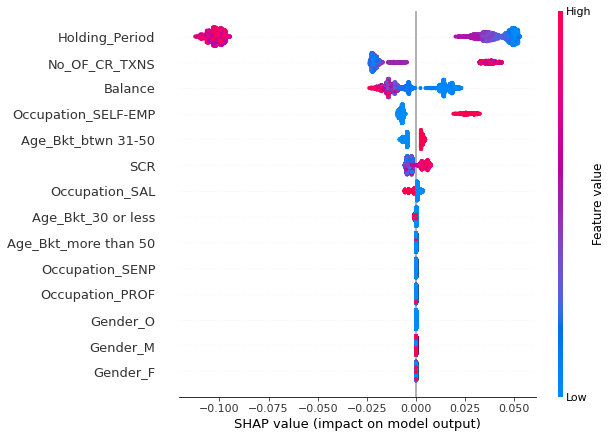

In [152]:
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns.tolist())

# Analysing value of information from the model

In [41]:
y_pred_rfc_X=rfc2.predict(X)
df_voi = pd.concat([df_probab[1], pd.DataFrame(y), pd.DataFrame(y_pred_rfc_X)], axis=1)
df_voi.rename(columns={1:"Probability", 'Target':'Event', 0: 'Pred_by_model'}, inplace=True)
df_voi.head()

,Probability,Event,Pred_by_model
0,0.59,0,1
1,0.49,0,0
2,0.51,0,1
3,0.38,0,0
4,0.37,0,0


In [42]:
df_voi.Event.value_counts()

0    18267
1     1733
Name: Event, dtype: int64

In [43]:
interested_cust=df_voi.Event.value_counts().loc[1]
not_interested_cust=df_voi.Event.value_counts().loc[0]
interested_cust, not_interested_cust

(1733, 18267)

In [44]:
# defining cost of approching a customer and the revenue generated per customer by the bank
cost_approach_cust = 20
revenue_interested_cust = 1000  
total_cust_survey = len(df_voi)

In [45]:
# Revenue generated by the bank from all interested customers when no model is used
Revenue_model_interested_cust = revenue_interested_cust*interested_cust
Revenue_model_interested_cust

1733000

In [46]:
# Expenditure by bank from approaching all customers when no model is used
expenses_approach = cost_approach_cust*total_cust_survey
expenses_approach

400000

In [47]:
# Net revenue generated by bank when no model is used
Net_Revenue_Model = Revenue_model_interested_cust-expenses_approach
Net_Revenue_Model

1333000

In [48]:
# Creating the pandas DataFrame for Base Case (No Model)
data_model = [['Base Case', 'No Model' , expenses_approach, Revenue_model_interested_cust, Net_Revenue_Model,'0','NA',  total_cust_survey]] 
df_model_voi = pd.DataFrame(data_model, columns = ['Model', 'Cutoff', 'Expenditure','Revenue','Net_Profit','VoI','Model_Accuracy(%)','Population Size'])

In [49]:
df_model_voi

,Model,Cutoff,Expenditure,Revenue,Net_Profit,VoI,Model_Accuracy(%),Population Size
0,Base Case,No Model,400000,1733000,1333000,0,NA,20000


In [50]:
# Running loop for different cutoff at Probabilty rates predicted by the model
cutoff_values=[0.50,0.45,0.42,0.40,0.35,0.30,1]
a=0
interested_cust_model = []
Revenue_model_interested_cust_model = []
Expenses_approach_model = []
Net_Revenue_Models = []
VOI_model = []
Observations_model = []
Accuracy_model = []
Cost_saved_not_approached_cust = []
model = ["Model 1", "Model 2" , "Model 3", "Model 4", "Model 5", "Model 6","Ideal Case"]
for i in cutoff_values:
    if i == 1:
        # Ideal Case- When only interested customers are approached(Model with 100% accuracy)
        df_model_voi_cutoff= df_voi.loc[df_voi.Event == 1]
        Observations_model.append(len(df_model_voi_cutoff))
        interested_cust_model.append(Observations_model[a])
        Revenue_model_interested_cust_model.append(revenue_interested_cust*interested_cust_model[a])
        Expenses_approach_model.append(cost_approach_cust*Observations_model[a])
        Net_Revenue_Models.append(Revenue_model_interested_cust_model[a]-Expenses_approach_model[a])
        VOI_model.append(Net_Revenue_Models[a]-Net_Revenue_Model)
        df_model_voi = df_model_voi.append(pd.DataFrame({'Model': model[a], 'Cutoff': 'NA',  'Expenditure' : Expenses_approach_model[a], 'Revenue' : Revenue_model_interested_cust_model[a],'Net_Profit':Net_Revenue_Models[a],'VoI': VOI_model[a], 'Model_Accuracy(%)': 1*100, 'Population Size': len(df_model_voi_cutoff)}, index=[a]), ignore_index=True)
    else:
        # Customers in the range of predicted probabilties > [0.50,0.45,0.42,0.40,0.35,0.30]
        df_model_voi_cutoff= df_voi.loc[df_voi.Probability >= i]
        interested_cust_model.append(df_model_voi_cutoff.Event.value_counts().loc[1])
        Observations_model.append(len(df_model_voi_cutoff))
        Revenue_model_interested_cust_model.append(revenue_interested_cust*interested_cust_model[a])
        Expenses_approach_model.append(cost_approach_cust*Observations_model[a])
        Cost_saved_not_approached_cust.append(cost_approach_cust*(total_cust_survey-Observations_model[a]))
        Net_Revenue_Models.append(Revenue_model_interested_cust_model[a]-Expenses_approach_model[a]+Cost_saved_not_approached_cust[a])
        VOI_model.append(Net_Revenue_Models[a]-Net_Revenue_Model)
        TP_model = df_model_voi_cutoff.query('Pred_by_model == 1 & Event == 1')
        no_TP_model = len(TP_model)
        TN_model = df_model_voi_cutoff.query('Pred_by_model == 0 & Event == 0')
        no_TN_model = len(TN_model)
        Accuracy_model.append((no_TP_model+no_TN_model)/Observations_model[a])
        df_model_voi = df_model_voi.append(pd.DataFrame({'Model': model[a], 'Cutoff': i, 'Expenditure' : Expenses_approach_model[a],'Revenue' : Revenue_model_interested_cust_model[a],'Net_Profit':Net_Revenue_Models[a], 'VoI': VOI_model[a], 'Model_Accuracy(%)': (Accuracy_model[a]*100), 'Population Size': len(df_model_voi_cutoff)}, index=[a]), ignore_index=True)
        a=a+1
df_model_voi

,Model,Cutoff,Expenditure,Revenue,Net_Profit,VoI,Model_Accuracy(%),Population Size
0,Base Case,No Model,400000,1733000,1333000,0,NA,20000
1,Model 1,0.50,175160,1334000,1383680,50680,15.23,8758
2,Model 2,0.45,227540,1496000,1440920,107920,33.32,11377
3,Model 3,0.42,258560,1599000,1481880,148880,40.52,12928
4,Model 4,0.40,270840,1617000,1475320,142320,43.09,13542
5,Model 5,0.35,400000,1733000,1333000,0,60.88,20000
6,Model 6,0.30,400000,1733000,1333000,0,60.88,20000
7,Ideal Case,NA,34660,1733000,1698340,365340,100,1733


<b>The most profitable segment will depend on the cost of approaching a customer and the revenue generated per customer, hence  can be determined by assigning different values to these two parameters. <b> <br>
    <b> Here, Value of Information(VoI) is the difference in the net profit generated by the model and the base case(when no model is used). <br>
        In this case when cost of approaching a customer=20 and revenue generated per customer=1000 , segment with probability cut off > 0.42 gives the highest Value of Information(VoI) and therefore is the most profitable segment. <br>